<a href="https://colab.research.google.com/github/wludin99/Fly-Angular-Integration/blob/main/Angular_Integration_Circuit_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a circuit to simulate the EPG-PEN-Delta7 angular integration ring attractor circuit on the Central Complex of the fly brain

This cell defines the rules for Nancy Lynch's SNN model

In [ ]:
#class definitions for nistantiation and simulation of nancy lynch's
# spiking neural network model
import numpy as np

class Network:
    '''describes whole network'''
    '''nodes: dict of lc neuron:bias'''
    '''inputs: dict of input neuron: input execution'''
    '''edges: dictionary of (u,v):weight'''

    def __init__(self, nodes, inputs, edges):
        self.nodes = {node: Neuron(self, node, nodes[node]) for node in nodes}
        self.edges = edges
        self.inputs = {inp:Input(inp) for inp in inputs}
        for node in self.nodes:
            self.nodes[node].get_inputs(self.edges)
        self.state = {node:self.nodes[node].get_state() for node in nodes}
        self.state.update({inp:self.inputs[inp].get_state(0) for inp in self.inputs})
        
    def __str__(self):
        ret = ''
        for node in self.nodes:
            ret += node + ': ' + str(self.nodes[node].get_state()) + ' \n'
        return ret
        
    def step(self):
        next_state = {node:self.nodes[node].new_state() for node in self.nodes}
        next_state.update({inp:self.inputs[inp].get_state(1) for inp in self.inputs})
        self.state = next_state

    def execute(self, steps=10):
#         print(self)
        for n in range(steps):
            self.step()
#             print(self)
 #inner class 1 is non-input neurons with firing determined internally
class Neuron:

    def __init__(self, net, name, bias, state=0):
        self.net = net
        self.name = name
        self.b = bias
        self.state = np.random.binomial(1,.5)
        
    def get_inputs(self, edges):
        self.inputs = {}
        for u,v in edges:
            if v == self.name:
                try: 
                    self.inputs[u] = edges[(u,v)]
                except:
                    self.inputs[u] = edges[(u,v)]

    def potential(self):
        pot = -self.b
        for u in self.inputs:
            weight = self.inputs[u]
            firing = self.net.state[u]
            pot += firing * weight
        return pot

    def prob(self):
        return 1/(1+np.e**-self.potential())
        
    def new_state(self):
        self.state = np.random.binomial(1, self.prob())
        return self.state
    
    def get_state(self):
        return self.state

#inner class 2 is input neurons with firing determined externally
class Input:

    def __init__(self, name):
        self.name = name
        self.state = 0

    def get_state(self, n):
        return self.state
            



In [ ]:
#threshhold dictionary
b = {
    'epg': 6,
    'pen': 3,
    'd7': 10-np.sqrt(2)
}

#weight dictionary
w = {
    'epg_epg': 6,
    'pen_epg': 0,
    'd7_epg': -6,
    
    'epg_pen': 0,
    'inputs_pen': 0   
}


#neurons
epgs = {'epg_' + str(n):b['epg'] for n in range(8)}
pens = {'penl_' + str(n):b['pen'] for n in range(8)}
pens.update( {'penr_' + str(n):b['pen'] for n in range(8)} )
delta_sevens = {'d7_' + str(n):b['d7'] for n in range(8)}

neurons = {**epgs, **pens, **delta_sevens}

#inputs

inputs = ['cw','ccw']

#edges
#into epg
epg_epg = {('epg_'+str(n),'epg_'+str(n)):w['epg_epg'] for n in range(8)}
epg_epg.update({('epg_'+str(n),'epg_'+str((n+1)%8)):w['epg_epg'] for n in range(8)})
epg_epg.update({('epg_'+str(n),'epg_'+str((n-1)%8)):w['epg_epg'] for n in range(8)})

pen_epg = {('penl_'+str(n), 'epg_'+str(n-1 % 8)):w['pen_epg'] for n in range(8)}
pen_epg.update({('penr_'+str(n), 'epg_'+str(n+1 % 8)):w['pen_epg'] for n in range(8)})

d7_epg = {('d7_'+str(m),'epg_'+str(n)):w['d7_epg'] for m in range(8) for n in range(8) if n%8 == m%8}

#into pen
epg_pen = {('epg_'+str(n),'penl_'+str(n)):w['epg_pen'] for n in range(8)}
epg_pen.update({('epg_'+str(n),'penr_'+str(n)):w['epg_pen'] for n in range(8)})

inputs_pen = {('ccw','penl_'+str(n)):w['inputs_pen'] for n in range(8)}
inputs_pen.update({('cw','penr_'+str(n)):w['inputs_pen'] for n in range(8)})


#into d7
epg_d7 = {('epg_'+str(n),'d7_'+str(m)):(1-np.cos((m-n)*np.pi/4))*4 for m in range(8) for n in range(8)}


edges = {**epg_epg, **epg_pen, **pen_epg, **epg_d7, **d7_epg, **inputs_pen}
# print(edges)


#create angular integration network
net = Network(neurons, inputs, edges)

#simulate stochastic firing of compass neurons
def epg_sim(steps=30):
#     print([net.nodes[neuron].get_state() for neuron in epgs])
    ret = []
    for n in range(steps):
        net.step()
        firing_epgs = [net.nodes[neuron].get_state() for neuron in epgs]
#         print(firing_epgs)
        try:
            avg = sum([firing_epgs[i]*i for i in range(8)])/sum([n for n in firing_epgs])
        except:
            avg = 0
#         print(avg)
        ret.append(avg)
    return ret
epg_sim()



#         convolve = [sum([firing[n]*(1+np.cos((m-n)*np.pi/4)) for n in range(8)]) for m in range(8)]
#         softmax = np.around(np.exp(convolve) / np.sum(np.exp(convolve)),2)
#         print(softmax)

[5.0,
 5.5,
 5.0,
 5.5,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.5,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 4.5,
 5.0,
 4.5,
 4.5,
 4.0,
 4.5]

Now we seem to have created a network that can we can stochastically simulate for an arbitrary number of steps
Let's see if this network has the desired behavior in a stable state. To do this we first create an animation that shows how the epg's fire over time using matplotlib animation

<IPython.core.display.Javascript object>


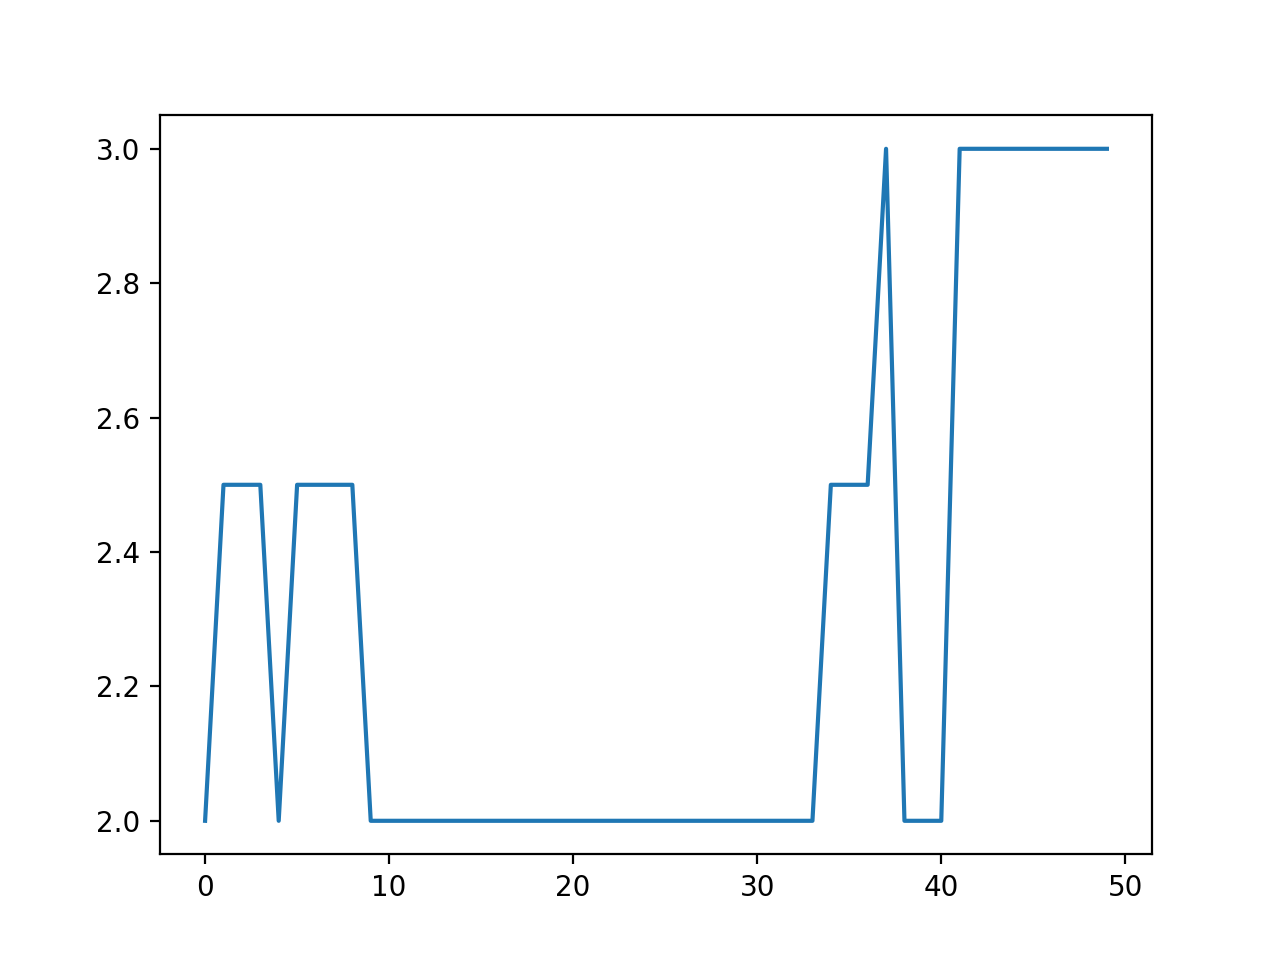

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

steps = 50
x = range(steps)
y = epg_sim(steps)
plt.plot(x,y)
plt.show()